# Carga de los Datos

In [ ]:
# import libraries
import torch
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt

from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

In [ ]:
# image path - Google Drive
data_path = "/content/drive/MyDrive/images/Axial"

# Cálculo de la media y la desviación estándar
Se calculan la media y la desviación estándar del conjunto de imágenes para realizar posteriormente en la estandarización de las mismas.

In [ ]:
# resizing
transform = transforms.Compose([transforms.Resize((64,64)),
                                transforms.ToTensor()])
# data loading
dataset = datasets.ImageFolder(root=data_path, transform=transform)
dataloader = torch.utils.data.DataLoader(dataset=dataset, batch_size=128)

In [ ]:
# mean and standard deviation
def get_mean_and_std(dataloader):
    channels_sum, channels_squared_sum, num_batches = 0, 0, 0
    for data, _ in dataloader:
        # Mean over batch, height and width, but not over the channels
        channels_sum += torch.mean(data, dim=[0,2,3])
        channels_squared_sum += torch.mean(data**2, dim=[0,2,3])
        num_batches += 1
    
    mean = channels_sum / num_batches
    std = (channels_squared_sum / num_batches - mean ** 2) ** 0.5

    return mean, std

In [ ]:
mean, std = get_mean_and_std(dataloader)

## Redimensionado y estandarización
Se definen las transformaciones a realizar para cada una de las imágenes del dataset:


*   Redimensionado
*   Estandarización

In [ ]:
transform = transforms.Compose([transforms.Resize((64,64)),
                                transforms.ToTensor(),
                                transforms.Normalize(mean, std)])

In [ ]:
data = datasets.ImageFolder(root=data_path, transform=transform)

In [ ]:
image, label = data[0]

In [ ]:
# image size and label
print(image.shape, label)

torch.Size([3, 64, 64]) 0


In [ ]:
# image classes
classes = data.classes

Label : Healthy


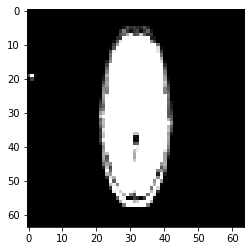

In [ ]:
# display an image
def display_img(img,label):
    print(f"Label : {data.classes[label]}")
    plt.imshow(img.permute(1,2,0), cmap='gray')

# display the first image in the dataset
display_img(*data[0])

In [ ]:
# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 32

In [ ]:
dataloaders = torch.utils.data.DataLoader(data, batch_size=batch_size, 
                                          shuffle=True, num_workers=num_workers)

In [ ]:
# percentage of training set to use as Test
test_size = 0.2
# percentage of training set to use as validation
valid_size = 0.15

In [ ]:
# obtain training indices that will be used for test
num_train = len(data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(test_size * num_train))
train_idx, test_idx = indices[split:], indices[:split]

In [ ]:
# obtain training indices that will be used for validation
num_train = len(train_idx)
indices = train_idx
split2 = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split2:], indices[:split2]

In [ ]:
# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)
test_sampler = SubsetRandomSampler(test_idx)

In [ ]:
# sizes for train, validation, test and all data
print(len(train_sampler))
print(len(valid_sampler))
print(len(test_sampler))
print(len(data))

1124
198
330
1652


In [ ]:
2# prepare data loaders
train_loader = torch.utils.data.DataLoader(data, batch_size=batch_size,
                                           sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, 
                                           sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, 
                                          sampler=test_sampler, num_workers=num_workers)

In [ ]:
# Visualizing the images from a batch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

def show_batch(dl):
    """Plot images grid of single batch"""
    for images, labels in dl:
        fig,ax = plt.subplots(figsize = (16,12))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images,nrow=16).permute(1,2,0))
        break
        
show_batch(train_loader)

# Red Neuronal Convolucional
Implementación de la red neuronal convolucional del modelo.

## Entrenamiento y validación:

In [ ]:
# import libraries
import torch.nn as nn
import torch.nn.functional as F

class ImageClassificationBase(nn.Module):
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch+1, result['train_loss'], result['val_loss'], result['val_acc']))

Arquitectura de la red neuronal convolucional:

In [ ]:
class MSClassification(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            # CNN-side
            # 1. Layer
            nn.Conv2d(3, 64, kernel_size = 3, stride = 1, padding = 1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            # 2. Layer
            nn.Conv2d(64, 64, kernel_size = 3, stride = 1, padding = 1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            # 3. Layer
            nn.Conv2d(64, 64, kernel_size = 3, stride = 1, padding = 1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            # 4. Layer
            nn.Conv2d(64, 64, kernel_size = 3, stride = 1, padding = 1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            # 5. Layer
            nn.Conv2d(64, 64, kernel_size = 3, stride = 1, padding = 1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            # fully-connected side
            nn.Flatten(),
            nn.Linear(16384,1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(256,2),
        )
    
    def forward(self, xb):
        return self.network(xb)

Hiperparámetros, entrenamiento y evaluación del modelo:

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

  
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

  
def fit(epochs, lr, model, train_loader, val_loader):
    history = []
    optimizer = torch.optim.Adam(model.parameters(),lr, weight_decay=1e-6)
    for epoch in range(epochs):
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    
    return history

Vista del modelo de CNN implementado:

In [ ]:
model = MSClassification()
model

MSClassification(
  (network): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): BatchNorm2d(64, e

Se utiliza, en caso de estar disponible, la GPU para realizar el entrenamiento del modelo:

In [ ]:
def get_default_device():
    """ Set Device to GPU or CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    

def to_device(data, device):
    "Move data to the device"
    if isinstance(data,(list,tuple)):
        return [to_device(x,device) for x in data]
    return data.to(device,non_blocking = True)

class DeviceDataLoader():
    """ Wrap a dataloader to move data to a device """
    
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
    
    def __iter__(self):
        """ Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b,self.device)
            
    def __len__(self):
        """ Number of batches """
        return len(self.dl)

¿Qué dispositivo se utiliza?

In [ ]:
device = get_default_device()
device

device(type='cpu')

Carga de los archivos para realizar el entrenamiento:

In [ ]:
# load data
train_loader = DeviceDataLoader(train_loader, device)
valid_loader = DeviceDataLoader(valid_loader, device)
to_device(model, device)

MSClassification(
  (network): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): BatchNorm2d(64, e

In [ ]:
#load the model to the device
model = to_device(MSClassification(),device)

Se establecen el número de epochs del entrenamiento y el learning rate:

In [ ]:
#set the no. of epochs and learning rate
num_epochs = 50
lr = 0.001

## Entrenamiento del modelo:

In [ ]:
# fitting the model on training data and record the result after each epoch
history = fit(num_epochs, lr, model, train_loader, valid_loader)

Epoch [1], train_loss: 0.4636, val_loss: 0.3749, val_acc: 0.8244
Epoch [2], train_loss: 0.3345, val_loss: 0.2511, val_acc: 0.9107
Epoch [3], train_loss: 0.2433, val_loss: 2.0392, val_acc: 0.4315
Epoch [4], train_loss: 0.2797, val_loss: 0.4457, val_acc: 0.8125
Epoch [5], train_loss: 0.2540, val_loss: 0.8247, val_acc: 0.6057
Epoch [6], train_loss: 0.1901, val_loss: 0.2630, val_acc: 0.8646
Epoch [7], train_loss: 0.2490, val_loss: 0.2195, val_acc: 0.9003
Epoch [8], train_loss: 0.1846, val_loss: 0.2507, val_acc: 0.8705
Epoch [9], train_loss: 0.1737, val_loss: 0.3630, val_acc: 0.7783
Epoch [10], train_loss: 0.1828, val_loss: 0.2477, val_acc: 0.9196
Epoch [11], train_loss: 0.2331, val_loss: 0.2434, val_acc: 0.9107
Epoch [12], train_loss: 0.2544, val_loss: 0.2985, val_acc: 0.8869
Epoch [13], train_loss: 0.2103, val_loss: 0.2352, val_acc: 0.8958
Epoch [14], train_loss: 0.1892, val_loss: 0.1701, val_acc: 0.9286
Epoch [15], train_loss: 0.1718, val_loss: 0.3205, val_acc: 0.8095
Epoch [16], train_l

Se obtiene el gráfico de evolución de la precisión en función del número de epochs:

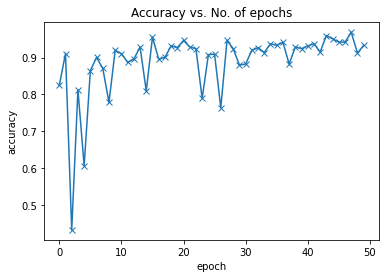

In [ ]:
def plot_accuracies(history):
    """ Plot the history of accuracies"""
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');
    
plot_accuracies(history)

Se obtiene el gráfico de evolución de la la función de pérdidas en función del número de epochs:

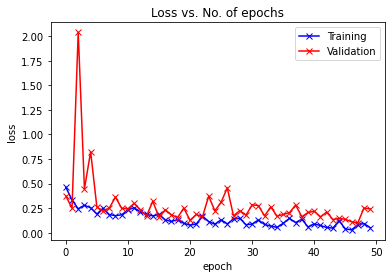

In [ ]:
def plot_losses(history):
    """ Plot the losses in each epoch"""
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

plot_losses(history)

## Evaluación / Test del modelo:

In [ ]:
# Apply the model on test dataset and Get the results
test_loader = DeviceDataLoader(test_loader, device)
result = evaluate(model, test_loader)
result

{'val_loss': 0.12253911793231964, 'val_acc': 0.9602272510528564}

### Métricas de la evaluación
Se obtienen en primer lugar las predicciones del modelo y las etiquetas correspondientes.

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

y_pred = []
y_true = []

# iterate over test data
for inputs, labels in test_loader:
        output = model(inputs) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

#### Matriz de confusión

(Text(0.5, 1.0, 'Confusion Matrix'), None)

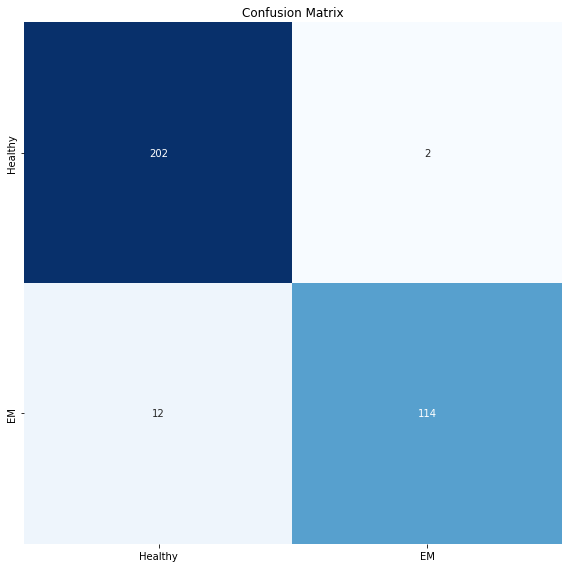

In [ ]:
# constant for classes
classes = ('Healthy', 'EM')
plt.figure(figsize = (8,8))
# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix, index=classes, columns=classes)
sn.heatmap(df_cm, annot=True, cbar=None, cmap="Blues", fmt="d")
plt.title("Confusion Matrix"), plt.tight_layout()

#### Resultados de la clasificación del modelo:

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=classes))

              precision    recall  f1-score   support

     Healthy       0.94      0.99      0.97       204
          EM       0.98      0.90      0.94       126

    accuracy                           0.96       330
   macro avg       0.96      0.95      0.95       330
weighted avg       0.96      0.96      0.96       330

